In [1]:
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

from util import plotScatterDecode, plotProgress, plotCompDecode, plotScatterEncode, addNoise

c:\users\user\anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load the datasets

In [2]:
(xTrain, _), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape((numTrain, dimInput))
xTest = xTest.reshape((numTest, dimInput))
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


## Declare the parameters and layers

In [3]:
numEpochs = 50
sizeBatch = 32
dimInter = 64
dimEncode = 2
stdEps = 1.0 
ratRecon = 1
nameOptim = 'adam'

## Construct the encoder and decoder

In [4]:
layEncInt = Dense(dimInter, activation='relu')
layMean = Dense(dimEncode)
laySigma = Dense(dimEncode)
layDecInt = Dense(dimInter, activation='relu')
layDecode = Dense(dimInput, activation='sigmoid')

inputs = Input(shape=(dimInput,))
interEncode = layEncInt(inputs)
zMean = layMean(interEncode)
zSigmaLog = laySigma(interEncode) # log for linear dense

def sampling(args):
    zMean, zSigmaLog = args
    epsilon = K.random_normal(shape=(K.shape(zMean)[0], dimEncode),
                              mean=0., stddev=stdEps)
    return zMean + K.exp(zSigmaLog) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
z = Lambda(sampling)([zMean, zSigmaLog])
encoder = Model(inputs, z)

inputZ = Input(shape=(dimEncode,))
interDecode = layDecInt(inputZ)
decode = layDecode(interDecode)
decoder = Model(inputZ, decode)

## Construct the autoencoder

In [5]:
vae = Model(inputs, decoder(encoder(inputs)))
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 50500     
_________________________________________________________________
model_2 (Model)              (None, 784)               51152     
Total params: 101,652
Trainable params: 101,652
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [6]:
def lossVAE(zMean, zSigmaLog):
    def loss(tensorInput, tensorDecode):
        lossRecon =  metrics.binary_crossentropy(tensorInput, tensorDecode)
        lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
#         lossKL = - 0.5 * K.mean(1 + zSigmaLog - K.square(zMean) - K.exp(zSigmaLog), axis=-1)
        return ratRecon * lossRecon + (1 - ratRecon) * lossKL
    return loss


vae.compile(optimizer=nameOptim, loss=lossVAE(zMean, zSigmaLog))
tic = time()
history = vae.fit(xTrain, xTrain,
                epochs=numEpochs,
                batch_size=sizeBatch,
                shuffle=True,
                validation_data=(xTest, xTest))
timeTrain = time() - tic

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 10s 168us/step - loss: 0.2496 - val_loss: 0.2242
Epoch 2/50
60000/60000 [==============================] - 8s 131us/step - loss: 0.2166 - val_loss: 0.2075
Epoch 3/50
60000/60000 [==============================] - 8s 130us/step - loss: 0.2043 - val_loss: 0.2016
Epoch 4/50
60000/60000 [==============================] - 9s 152us/step - loss: 0.1999 - val_loss: 0.1985
Epoch 5/50
60000/60000 [==============================] - 9s 149us/step - loss: 0.1971 - val_loss: 0.1963
Epoch 6/50
60000/60000 [==============================] - 9s 152us/step - loss: 0.1952 - val_loss: 0.1947
Epoch 7/50
60000/60000 [==============================] - 9s 151us/step - loss: 0.1937 - val_loss: 0.1938
Epoch 8/50
60000/60000 [==============================] - 9s 148us/step - loss: 0.1926 - val_loss: 0.1926
Epoch 9/50
60000/60000 [==============================] - 9s 152us/step - loss: 0.1916 - val_loss: 0.

## Show the historical training progress 

traing consumed: 497.51543855667114 seconds


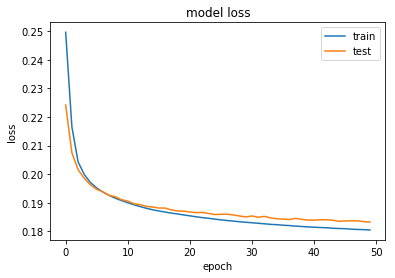

In [7]:
print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

## Compare original digitals with the decoding results

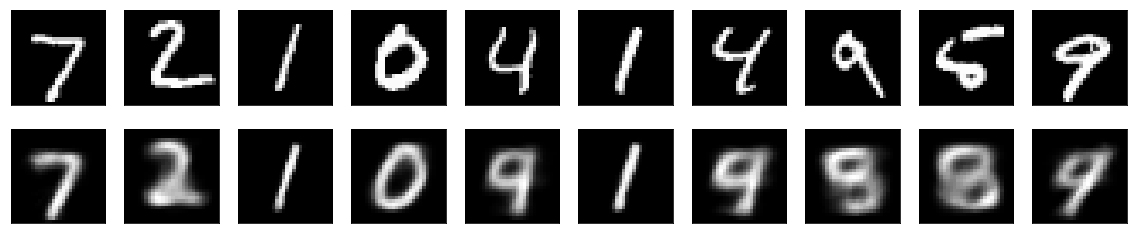

In [9]:
plotCompDecode(xTest, decodeTest)

## Plot the scatter of the encoding space

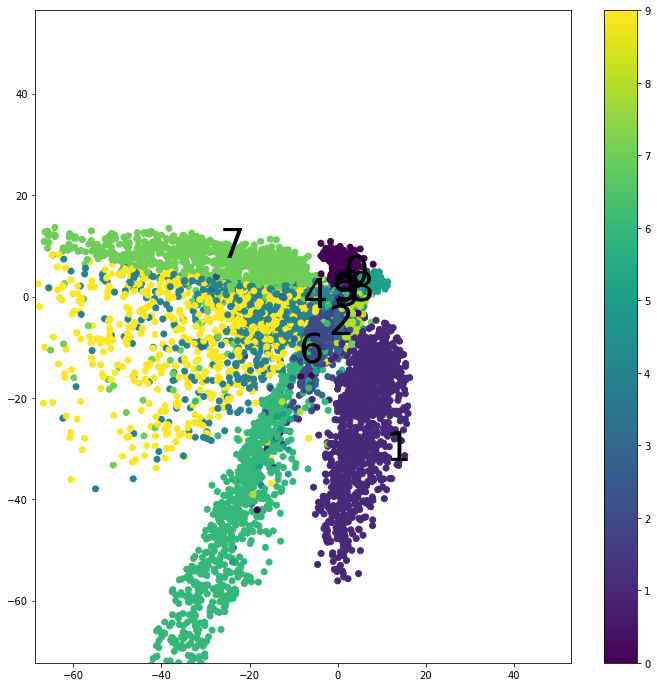

In [10]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

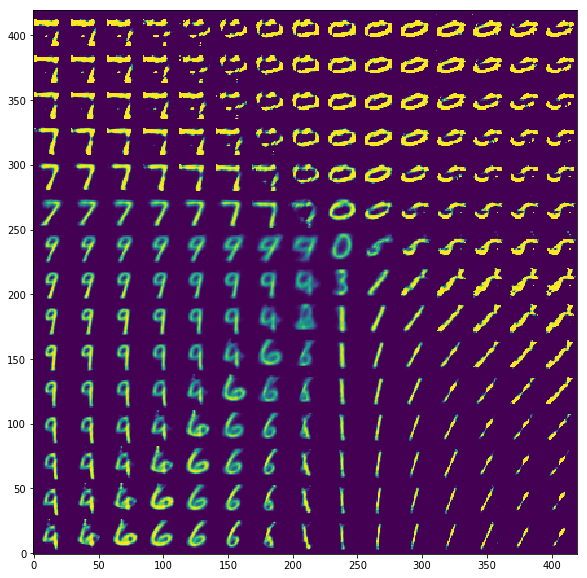

In [11]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, sizeDigit, xlim, ylim)

In [12]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

497.51543855667114 0.18050433860619863 0.18326721003055574 -0.00115615
